In [1]:
#Import Python Libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from IPython.display import display, HTML



In [4]:

# IMPORTING THE ALREADY EXISTING SIMILARITY MATRIX
sim_matrix=pd.read_csv('sim_matrix_paper89-full.csv')
sim_matrix.index = sim_matrix.userId
sim_matrix = sim_matrix.drop(columns={'userId'})
print('imported sim_matrix')
display(HTML(sim_matrix.head(7).to_html()))

imported sim_matrix


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,

In [ ]:
# PRE-PROCESSING PART. - JUST ONCE, TO GET THE CSV OF THE FULL MATRIX

# 1. It is required to add the redundant values to the matrix

sim_matrix2 = sim_matrix.copy(deep=True)

for i in range(len(sim_matrix2)):
    for j in range(0, i):
        sim_matrix2.iloc[[j],[i]] = sim_matrix2.iloc[i][j]
    display(HTML(sim_matrix2.head(7).to_html()))
    
sim_matrix2.to_csv('sim_matrix_paper9-wholematrix.csv')


In [2]:
# PAPER 9. PRE-PROCESSING. STEP 0.

#IMPORTING THE ALREADY EXISTING SIMILARITY MATRIX
sim_matrix=pd.read_csv('sim_matrix_paper9-wholematrix.csv')
sim_matrix.index = sim_matrix.userId
sim_matrix = sim_matrix.drop(columns={'userId'})
print('imported sim_matrix')
sim_matrix = sim_matrix.apply(pd.to_numeric)
display(HTML(sim_matrix.head(7).to_html()))

imported sim_matrix


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.996091,0.997158,0.985855,0.994150,0.997652,0.995813,0.993238,0.997214,0.997196,0.997218,0.997542,0.996851,0.998840,0.949473,0.997769,0.980075,0.997532,0.980335,0.995283,0.992499,0.990710,0.964589,0.998494,0.998556,0.991675,0.998311,0.996172,0.998703,0.946200,0.995352,0.997196,0.993859,0.989395,0.999126,0.994633,0.997592,0.992437,0.996323,0.996453,0.989312,0.995459,0.995757,0.998463,0.998436,0.996193,0.997456,0.976831,0.995175,0.997712,0.997685,0.995899,0.997937,0.997183,0.997653,0.973643,0.987557,0.996091,0.996410,0.996051,0.992681,0.996430,0.994155,0.998283,0.997799,0.996812,0.994099,0.993709,0.994483,0.994330,0.998021,0.992290,0.929914,0.996515,0.993576,0.998544,0.986790,0.982133,0.998193,0.997678,0.990600,0.997626,0.990

In [66]:
# PAPER 9. STEP 1.

# REPRESENTATION OF EACH USER BY THE DISTRIBUTION OF USER-USER SIMILARITY
u_mean = np.empty(0, dtype=float)
user_ids = np.empty(0, dtype=int)
q1 = np.empty(0, dtype=float)
q2 = np.empty(0, dtype=float)
q3 = np.empty(0, dtype=float)
std = np.empty(0, dtype=float)
skewness = np.empty(0, dtype=float)

sim_matrix2 = sim_matrix.copy(deep=True)
# through the rows, keeping the important values of each user
for i in range(0, len(sim_matrix2)):
    
    user_ids = np.append(user_ids,sim_matrix2.index[i])
    q1 = np.append(q1, sim_matrix2.iloc[i].quantile(q=0.25))
    q2 = np.append(q2, sim_matrix2.iloc[i].quantile(q=0.5))
    q3 = np.append(q3, sim_matrix2.iloc[i].quantile(q=0.75))   
    std = np.append(std, sim_matrix2.iloc[i].std(axis=0))    
    skewness = np.append(skewness , sim_matrix2.iloc[i].skew())                         
    u_mean = np.append(u_mean, sim_matrix2.iloc[i].mean())
            


sim_distr = pd.DataFrame({'User ID': user_ids, 'q1': q1, 'q2': q2, 'q3': q3, 'Mean': u_mean, 'STD': std, 'Skewness': skewness}) 

display(HTML(sim_distr.head(5).to_html()))

print('dense : {:0.2f} bytes'.format(sim_distr.memory_usage().sum() / 1e3))
sim_distr.to_csv('sim_distribution_statistics-9.csv')  

NameError: name 'sim_matrix' is not defined

In [68]:
# # PAPER 9. STEP 2.

# importing the already existing distribution statistics, if already existing
sim_distr=pd.read_csv('sim_distribution_statistics-9.csv')
sim_distr = sim_distr.drop(columns={'Unnamed: 0'})
df = pd.read_csv('MovieLens.csv')
# FILTERING PART 
# examples: mean < q1 of mean, skew > q3 of skew
n_users_added = 0
df_filtered = pd.DataFrame()
sim_distr_filtered = pd.DataFrame()
for i in sim_distr.index:
    if ( sim_distr.loc[i].Mean < sim_distr.Mean.quantile(q=0.25)):
        n_users_added += 1
        id_i =  df['userId']==i
        df_id_i = df[id_i]
        df_filtered = pd.concat([df_filtered, df_id_i], axis=0) 
        
        id_i =  sim_distr['User ID']==i
        df_id_i = sim_distr[id_i]        
        sim_distr_filtered = pd.concat([sim_distr_filtered, df_id_i], axis=0)            
    elif  (sim_distr.loc[i].Skewness > sim_distr.Skewness.quantile(q=0.75)):
        n_users_added += 1
        id_i =  df['userId']==i
        df_id_i = df[id_i]
        df_filtered = pd.concat([df_filtered, df_id_i], axis=0) 
        
        id_i =  sim_distr['User ID']==i
        df_id_i = sim_distr[id_i]        
        sim_distr_filtered = pd.concat([sim_distr_filtered, df_id_i], axis=0)            
        
        
print('number of users added:', n_users_added)    
print('Final number of users',df_filtered.shape)
display(HTML(sim_distr_filtered.head(3).to_html()))
df.index = df.userId
df = df.drop(columns={'userId'})
   

number of users added: 329
Final number of users (45239, 3)


,User ID,q1,q2,q3,Mean,STD,Skewness
2,3,0.990880,0.994589,0.996222,0.991407,0.009598,-4.662052
9,10,0.990374,0.994412,0.996110,0.991176,0.009631,-4.581044
10,11,0.990187,0.994197,0.996028,0.990907,0.009857,-4.470687


,User ID,q1,q2,q3,Mean,STD,Skewness,NOF
2,3,0.990880,0.994589,0.996222,0.991407,0.009598,-4.662052,-1.272363
9,10,0.990374,0.994412,0.996110,0.991176,0.009631,-4.581044,-1.172332
10,11,0.990187,0.994197,0.996028,0.990907,0.009857,-4.470687,-1.176714


<AxesSubplot:ylabel='Frequency'>

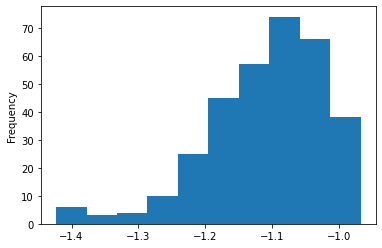

In [69]:
# # PAPER 9. STEP 3.
# OUTLIER DETECTION

from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=150)
clf.fit(df_filtered)
array = clf.negative_outlier_factor_

df_nof = pd.DataFrame(array, columns=['NOF'])
sim_distr_filtered2 = sim_distr_filtered.join(df_nof)
display(HTML(sim_distr_filtered2.head(3).to_html()))

# LET'S SEE FIRST THE DISTRIBUTION OF THE LOF
distr=sim_distr_filtered2['NOF']
distr.plot(kind="hist")




In [70]:
# NOW, WE ARE GOING TO TRY DIFFERENT VALUES
# We need to keep the users that have those ids to perform different evaluations   
df=pd.read_csv('final_errors.csv')

In [71]:
# LOF = 0
lof_threshold = 0
list_id_gsu =  np.empty(0, dtype=int)
for i in sim_distr_filtered2.index:   
    if (sim_distr_filtered2.NOF[i]< lof_threshold):
            id_gsu = sim_distr_filtered2['User ID'][i]
            list_id_gsu = np.append(list_id_gsu, id_gsu)
print('id gsu list: ', list_id_gsu)  
print('number of GSU:', len(list_id_gsu))
filtered_df = pd.DataFrame()
non_gsu_df = df.copy(deep=True)
for i in list_id_gsu:
    id_i =  df['userId']==i
    non_gsu_df = non_gsu_df[non_gsu_df.userId != i]

    df_id_i = df[id_i]
    filtered_df = pd.concat([filtered_df, df_id_i], axis=0)

non_gsu_df.index = non_gsu_df.userId
non_gsu_df = non_gsu_df.drop(columns={'userId'})
filtered_df.index = filtered_df.userId
filtered_df = filtered_df.drop(columns={'userId'})

display(HTML(filtered_df.head(3).to_html()))
display(HTML(non_gsu_df.head(3).to_html()))


non_gsu_df.to_csv('non-gsu_users_9_LOF_0.csv')
filtered_df.to_csv('gsu_users_9_LOF_0.csv')

id gsu list:  [  3  10  11  13  14  16  17  18  21  22  23  24  28  29  33  34  40  43
  44  47  50  52  53  54  55  56  57  63  64  69  70  72  75  76  77  79
  80  82  85  86  87  90  94  95  98  99 101 104 106 110 111 112 113 116
 117 118 121 122 124 126 127 128 129 133 134 148 149 151 153 155 156 157
 161 164 169 173 175 176 184 186 190 194 195 198 199 203 204 206 208 211
 212 213 219 220 221 222 223 225 226 228 231 232 234 235 238 239 241 242
 246 248 249 250 252 254 255 257 261 264 267 268 269 274 275 279 282 283
 284 285 286 288 291 293 294 295 298 300 301 302 304 305 307 308 309 310
 311 312 314 316 317 318 321 324 328 330 331 334 335 336 340 341 343 344
 345 347 348 349 352 354 355 356 357 358 360 362 363 365 366 367 370 371
 372 373 374 376 379 381 383 386 387 388 391 392 396 398 401 402 404 406
 407 408 412 413 417 422 423 425 426 427 428 429 430 432 433 435 436 437
 438 441 443 444 449 450 451 456 458 459 460 462 463 465 467 468 469 470
 471 474 476 479 480 481 483 484 489 

,error
userId,
3,0.592084
10,0.612389
11,0.686842


,error
userId,
1,0.706490
2,0.682630
4,0.594752


In [72]:
from statsmodels.stats.weightstats import ttest_ind
print('The second value of the results is the p-value')
print(' ')
print('T-Test between NON-GSU and GSU for LOF=0')
tt = ttest_ind(non_gsu_df.error, filtered_df.error)
print('')
print(tt)
print('')
non_gsu_mae = non_gsu_df.error.mean()
gsu_mae = filtered_df.error.mean()
print('MAE NON-GSU: ', non_gsu_mae)
print('MAE GSU: ', gsu_mae)

The second value of the results is the p-value
 
T-Test between NON-GSU and GSU for LOF=0

(1.3083468433221994, 0.19120501131824966, 669.0)

MAE NON-GSU:  0.7331460957580179
MAE GSU:  0.7103696231920726


In [41]:
# LOF = -0.1
lof_threshold = -0.1
list_id_gsu =  np.empty(0, dtype=int)
for i in sim_distr_filtered2.index:
    
    if (sim_distr_filtered2.NOF[i]< lof_threshold):
            id_gsu = sim_distr_filtered2['User ID'][i]
            list_id_gsu = np.append(list_id_gsu, id_gsu)
print('id gsu list: ', list_id_gsu)  
print('number of GSU:', len(list_id_gsu))
filtered_df = pd.DataFrame()
non_gsu_df = df.copy(deep=True)
for i in list_id_gsu:
    id_i =  df['userId']==i
    non_gsu_df = non_gsu_df[non_gsu_df.userId != i]

    df_id_i = df[id_i]
    filtered_df = pd.concat([filtered_df, df_id_i], axis=0)

display(HTML(filtered_df.head(3).to_html()))
display(HTML(non_gsu_df.head(3).to_html()))
non_gsu_df.index = non_gsu_df.userId
non_gsu_df = non_gsu_df.drop(columns={'userId'})

filtered_df.index = filtered_df.userId
filtered_df = filtered_df.drop(columns={'userId'})

non_gsu_df.to_csv('non-gsu_users_9_LOF_0.1.csv')
filtered_df.to_csv('gsu_users_9_LOF_0.1.csv')  


#np.savetxt('gsu_users_9_LOF_0.1.txt', filtered_df.values, fmt='%g')
#np.savetxt('non-gsu_users_9_LOF_0.1.txt', non_gsu_df.values, fmt='%g')

id gsu list:  [  3  10  11  13  14  16  17  18  21  22  23  24  28  29  33  34  40  43
  44  47  50  52  53  54  55  56  57  63  64  69  70  72  75  76  77  79
  80  82  85  86  87  90  94  95  98  99 101 104 106 110 111 112 113 116
 117 118 121 122 124 126 127 128 129 133 134 148 149 151 153 155 156 157
 161 164 169 173 175 176 184 186 190 194 195 198 199 203 204 206 208 211
 212 213 219 220 221 222 223 225 226 228 231 232 234 235 238 239 241 242
 246 248 249 250 252 254 255 257 261 264 267 268 269 274 275 279 282 283
 284 285 286 288 291 293 294 295 298 300 301 302 304 305 307 308 309 310
 311 312 314 316 317 318 321 324 328 330 331 334 335 336 340 341 343 344
 345 347 348 349 352 354 355 356 357 358 360 362 363 365 366 367 370 371
 372 373 374 376 379 381 383 386 387 388 391 392 396 398 401 402 404 406
 407 408 412 413 417 422 423 425 426 427 428 429 430 432 433 435 436 437
 438 441 443 444 449 450 451 456 458 459 460 462 463 465 467 468 469 470
 471 474 476 479 480 481 483 484 489 

,userId,error
2,3,0.592084
9,10,0.612389
10,11,0.686842


,userId,error
0,1,0.706490
1,2,0.682630
3,4,0.594752


In [42]:
from statsmodels.stats.weightstats import ttest_ind
print('The second value of the results is the p-value')
print(' ')
print('T-Test between NON-GSU and GSU for LOF=0')
tt = ttest_ind(non_gsu_df.error, filtered_df.error)
print('')
print(tt)


The second value of the results is the p-value
 
T-Test between NON-GSU and GSU for LOF=0

(1.3083468433221994, 0.19120501131824966, 669.0)


In [43]:
# LOF = -0.2
lof_threshold = -0.2
list_id_gsu =  np.empty(0, dtype=int)
for i in sim_distr_filtered2.index:
    
    if (sim_distr_filtered2.NOF[i]< lof_threshold):
            id_gsu = sim_distr_filtered2['User ID'][i]
            list_id_gsu = np.append(list_id_gsu, id_gsu)
print('id gsu list: ', list_id_gsu)  
print('number of GSU:', len(list_id_gsu))

filtered_df = pd.DataFrame()
non_gsu_df = df.copy(deep=True)
for i in list_id_gsu:
    id_i =  df['userId']==i
    non_gsu_df = non_gsu_df[non_gsu_df.userId != i]

    df_id_i = df[id_i]
    filtered_df = pd.concat([filtered_df, df_id_i], axis=0)

display(HTML(filtered_df.head(3).to_html()))
display(HTML(non_gsu_df.head(3).to_html()))


non_gsu_df.to_csv('non-gsu_users_9_LOF_0.2.csv')
filtered_df.to_csv('gsu_users_9_LOF_0.2.csv')  

  

np.savetxt('gsu_users_9_LOF_0.2.txt', filtered_df.values, fmt='%g')
np.savetxt('non-gsu_users_9_LOF_0.2.txt', non_gsu_df.values, fmt='%g')

id gsu list:  [  3  10  11  13  14  16  17  18  21  22  23  24  28  29  33  34  40  43
  44  47  50  52  53  54  55  56  57  63  64  69  70  72  75  76  77  79
  80  82  85  86  87  90  94  95  98  99 101 104 106 110 111 112 113 116
 117 118 121 122 124 126 127 128 129 133 134 148 149 151 153 155 156 157
 161 164 169 173 175 176 184 186 190 194 195 198 199 203 204 206 208 211
 212 213 219 220 221 222 223 225 226 228 231 232 234 235 238 239 241 242
 246 248 249 250 252 254 255 257 261 264 267 268 269 274 275 279 282 283
 284 285 286 288 291 293 294 295 298 300 301 302 304 305 307 308 309 310
 311 312 314 316 317 318 321 324 328 330 331 334 335 336 340 341 343 344
 345 347 348 349 352 354 355 356 357 358 360 362 363 365 366 367 370 371
 372 373 374 376 379 381 383 386 387 388 391 392 396 398 401 402 404 406
 407 408 412 413 417 422 423 425 426 427 428 429 430 432 433 435 436 437
 438 441 443 444 449 450 451 456 458 459 460 462 463 465 467 468 469 470
 471 474 476 479 480 481 483 484 489 

,userId,error
2,3,0.592084
9,10,0.612389
10,11,0.686842


,userId,error
0,1,0.706490
1,2,0.682630
3,4,0.594752


In [44]:
# LOF = -0.3
lof_threshold = -0.3
list_id_gsu =  np.empty(0, dtype=int)
for i in sim_distr_filtered2.index:
    
    if (sim_distr_filtered2.NOF[i]< lof_threshold):
            id_gsu = sim_distr_filtered2['User ID'][i]
            list_id_gsu = np.append(list_id_gsu, id_gsu)
print('id gsu list: ', list_id_gsu)  
print('number of GSU:', len(list_id_gsu))

filtered_df = pd.DataFrame()
non_gsu_df = df.copy(deep=True)
for i in list_id_gsu:
    id_i =  df['userId']==i
    non_gsu_df = non_gsu_df[non_gsu_df.userId != i]

    df_id_i = df[id_i]
    filtered_df = pd.concat([filtered_df, df_id_i], axis=0)

display(HTML(filtered_df.head(3).to_html()))
display(HTML(non_gsu_df.head(3).to_html()))


non_gsu_df.to_csv('non-gsu_users_9_LOF_0.3.csv')
filtered_df.to_csv('gsu_users_9_LOF_0.3.csv')  


np.savetxt('gsu_users_9_LOF_0.3.txt', filtered_df.values, fmt='%g')
np.savetxt('non-gsu_users_9_LOF_0.3.txt', non_gsu_df.values, fmt='%g')

id gsu list:  [  3  10  11  13  14  16  17  18  21  22  23  24  28  29  33  34  40  43
  44  47  50  52  53  54  55  56  57  63  64  69  70  72  75  76  77  79
  80  82  85  86  87  90  94  95  98  99 101 104 106 110 111 112 113 116
 117 118 121 122 124 126 127 128 129 133 134 148 149 151 153 155 156 157
 161 164 169 173 175 176 184 186 190 194 195 198 199 203 204 206 208 211
 212 213 219 220 221 222 223 225 226 228 231 232 234 235 238 239 241 242
 246 248 249 250 252 254 255 257 261 264 267 268 269 274 275 279 282 283
 284 285 286 288 291 293 294 295 298 300 301 302 304 305 307 308 309 310
 311 312 314 316 317 318 321 324 328 330 331 334 335 336 340 341 343 344
 345 347 348 349 352 354 355 356 357 358 360 362 363 365 366 367 370 371
 372 373 374 376 379 381 383 386 387 388 391 392 396 398 401 402 404 406
 407 408 412 413 417 422 423 425 426 427 428 429 430 432 433 435 436 437
 438 441 443 444 449 450 451 456 458 459 460 462 463 465 467 468 469 470
 471 474 476 479 480 481 483 484 489 

,userId,error
2,3,0.592084
9,10,0.612389
10,11,0.686842


,userId,error
0,1,0.706490
1,2,0.682630
3,4,0.594752


In [45]:
# LOF = -0.4
lof_threshold = -0.4
list_id_gsu =  np.empty(0, dtype=int)
for i in sim_distr_filtered2.index:
    
    if (sim_distr_filtered2.NOF[i]< lof_threshold):
            id_gsu = sim_distr_filtered2['User ID'][i]
            list_id_gsu = np.append(list_id_gsu, id_gsu)
print('id gsu list: ', list_id_gsu)  
print('number of GSU:', len(list_id_gsu))

filtered_df = pd.DataFrame()
non_gsu_df = df.copy(deep=True)
for i in list_id_gsu:
    id_i =  df['userId']==i
    non_gsu_df = non_gsu_df[non_gsu_df.userId != i]

    df_id_i = df[id_i]
    filtered_df = pd.concat([filtered_df, df_id_i], axis=0)

display(HTML(filtered_df.head(3).to_html()))
display(HTML(non_gsu_df.head(3).to_html()))


non_gsu_df.to_csv('non-gsu_users_9_LOF_0.4.csv')
filtered_df.to_csv('gsu_users_9_LOF_0.4.csv')  


np.savetxt('gsu_users_9_LOF_0.4.txt', filtered_df.values, fmt='%g')
np.savetxt('non-gsu_users_9_LOF_0.4.txt', non_gsu_df.values, fmt='%g')

id gsu list:  [  3  10  11  13  14  16  17  18  21  22  23  24  28  29  33  34  40  43
  44  47  50  52  53  54  55  56  57  63  64  69  70  72  75  76  77  79
  80  82  85  86  87  90  94  95  98  99 101 104 106 110 111 112 113 116
 117 118 121 122 124 126 127 128 129 133 134 148 149 151 153 155 156 157
 161 164 169 173 175 176 184 186 190 194 195 198 199 203 204 206 208 211
 212 213 219 220 221 222 223 225 226 228 231 232 234 235 238 239 241 242
 246 248 249 250 252 254 255 257 261 264 267 268 269 274 275 279 282 283
 284 285 286 288 291 293 294 295 298 300 301 302 304 305 307 308 309 310
 311 312 314 316 317 318 321 324 328 330 331 334 335 336 340 341 343 344
 345 347 348 349 352 354 355 356 357 358 360 362 363 365 366 367 370 371
 372 373 374 376 379 381 383 386 387 388 391 392 396 398 401 402 404 406
 407 408 412 413 417 422 423 425 426 427 428 429 430 432 433 435 436 437
 438 441 443 444 449 450 451 456 458 459 460 462 463 465 467 468 469 470
 471 474 476 479 480 481 483 484 489 

,userId,error
2,3,0.592084
9,10,0.612389
10,11,0.686842


,userId,error
0,1,0.706490
1,2,0.682630
3,4,0.594752


In [46]:
# LOF = -0.5
lof_threshold = -0.5
list_id_gsu =  np.empty(0, dtype=int)
for i in sim_distr_filtered2.index:
    
    if (sim_distr_filtered2.NOF[i]< lof_threshold):
            id_gsu = sim_distr_filtered2['User ID'][i]
            list_id_gsu = np.append(list_id_gsu, id_gsu)
print('id gsu list: ', list_id_gsu)  
print('number of GSU:', len(list_id_gsu))

filtered_df = pd.DataFrame()
non_gsu_df = df.copy(deep=True)
for i in list_id_gsu:
    id_i =  df['userId']==i
    non_gsu_df = non_gsu_df[non_gsu_df.userId != i]

    df_id_i = df[id_i]
    filtered_df = pd.concat([filtered_df, df_id_i], axis=0)


display(HTML(filtered_df.head(3).to_html()))
display(HTML(non_gsu_df.head(3).to_html()))


non_gsu_df.to_csv('non-gsu_users_9_LOF_0.5.csv')
filtered_df.to_csv('gsu_users_9_LOF_0.5.csv')  


np.savetxt('gsu_users_9_LOF_0.5.txt', filtered_df.values, fmt='%g')
np.savetxt('non-gsu_users_9_LOF_0.5.txt', non_gsu_df.values, fmt='%g')

id gsu list:  [  3  10  11  13  14  16  17  18  21  22  23  24  28  29  33  34  40  43
  44  47  50  52  53  54  55  56  57  63  64  69  70  72  75  76  77  79
  80  82  85  86  87  90  94  95  98  99 101 104 106 110 111 112 113 116
 117 118 121 122 124 126 127 128 129 133 134 148 149 151 153 155 156 157
 161 164 169 173 175 176 184 186 190 194 195 198 199 203 204 206 208 211
 212 213 219 220 221 222 223 225 226 228 231 232 234 235 238 239 241 242
 246 248 249 250 252 254 255 257 261 264 267 268 269 274 275 279 282 283
 284 285 286 288 291 293 294 295 298 300 301 302 304 305 307 308 309 310
 311 312 314 316 317 318 321 324 328 330 331 334 335 336 340 341 343 344
 345 347 348 349 352 354 355 356 357 358 360 362 363 365 366 367 370 371
 372 373 374 376 379 381 383 386 387 388 391 392 396 398 401 402 404 406
 407 408 412 413 417 422 423 425 426 427 428 429 430 432 433 435 436 437
 438 441 443 444 449 450 451 456 458 459 460 462 463 465 467 468 469 470
 471 474 476 479 480 481 483 484 489 

,userId,error
2,3,0.592084
9,10,0.612389
10,11,0.686842


,userId,error
0,1,0.706490
1,2,0.682630
3,4,0.594752


In [47]:
# LOF = -0.6
lof_threshold = -0.6
list_id_gsu =  np.empty(0, dtype=int)
for i in sim_distr_filtered2.index:
    
    if (sim_distr_filtered2.NOF[i]< lof_threshold):
            id_gsu = sim_distr_filtered2['User ID'][i]
            list_id_gsu = np.append(list_id_gsu, id_gsu)
print('id gsu list: ', list_id_gsu)  
print('number of GSU:', len(list_id_gsu))

filtered_df = pd.DataFrame()
non_gsu_df = df.copy(deep=True)
for i in list_id_gsu:
    id_i =  df['userId']==i
    non_gsu_df = non_gsu_df[non_gsu_df.userId != i]

    df_id_i = df[id_i]
    filtered_df = pd.concat([filtered_df, df_id_i], axis=0)


display(HTML(filtered_df.head(3).to_html()))
display(HTML(non_gsu_df.head(3).to_html()))


non_gsu_df.to_csv('non-gsu_users_9_LOF_0.6.csv')
filtered_df.to_csv('gsu_users_9_LOF_0.6.csv')  


np.savetxt('gsu_users_9_LOF_0.6.txt', filtered_df.values, fmt='%g')
np.savetxt('non-gsu_users_9_LOF_0.6.txt', non_gsu_df.values, fmt='%g')

id gsu list:  [  3  10  11  13  14  16  17  18  21  22  23  24  28  29  33  34  40  43
  44  47  50  52  53  54  55  56  57  63  64  69  70  72  75  76  77  79
  80  82  85  86  87  90  94  95  98  99 101 104 106 110 111 112 113 116
 117 118 121 122 124 126 127 128 129 133 134 148 149 151 153 155 156 157
 161 164 169 173 175 176 184 186 190 194 195 198 199 203 204 206 208 211
 212 213 219 220 221 222 223 225 226 228 231 232 234 235 238 239 241 242
 246 248 249 250 252 254 255 257 261 264 267 268 269 274 275 279 282 283
 284 285 286 288 291 293 294 295 298 300 301 302 304 305 307 308 309 310
 311 312 314 316 317 318 321 324 328 330 331 334 335 336 340 341 343 344
 345 347 348 349 352 354 355 356 357 358 360 362 363 365 366 367 370 371
 372 373 374 376 379 381 383 386 387 388 391 392 396 398 401 402 404 406
 407 408 412 413 417 422 423 425 426 427 428 429 430 432 433 435 436 437
 438 441 443 444 449 450 451 456 458 459 460 462 463 465 467 468 469 470
 471 474 476 479 480 481 483 484 489 

,userId,error
2,3,0.592084
9,10,0.612389
10,11,0.686842


,userId,error
0,1,0.706490
1,2,0.682630
3,4,0.594752


In [48]:
# LOF = -0.7
lof_threshold = -0.7
list_id_gsu =  np.empty(0, dtype=int)
for i in sim_distr_filtered2.index:
    
    if (sim_distr_filtered2.NOF[i]< lof_threshold):
            id_gsu = sim_distr_filtered2['User ID'][i]
            list_id_gsu = np.append(list_id_gsu, id_gsu)
print('id gsu list: ', list_id_gsu)  
print('number of GSU:', len(list_id_gsu))

filtered_df = pd.DataFrame()
non_gsu_df = df.copy(deep=True)
for i in list_id_gsu:
    id_i =  df['userId']==i
    non_gsu_df = non_gsu_df[non_gsu_df.userId != i]

    df_id_i = df[id_i]
    filtered_df = pd.concat([filtered_df, df_id_i], axis=0)


display(HTML(filtered_df.head(3).to_html()))
display(HTML(non_gsu_df.head(3).to_html()))


non_gsu_df.to_csv('non-gsu_users_9_LOF_0.7.csv')
filtered_df.to_csv('gsu_users_9_LOF_0.7.csv')  


np.savetxt('gsu_users_9_LOF_0.7.txt', filtered_df.values, fmt='%g')
np.savetxt('non-gsu_users_9_LOF_0.7.txt', non_gsu_df.values, fmt='%g')

id gsu list:  [  3  10  11  13  14  16  17  18  21  22  23  24  28  29  33  34  40  43
  44  47  50  52  53  54  55  56  57  63  64  69  70  72  75  76  77  79
  80  82  85  86  87  90  94  95  98  99 101 104 106 110 111 112 113 116
 117 118 121 122 124 126 127 128 129 133 134 148 149 151 153 155 156 157
 161 164 169 173 175 176 184 186 190 194 195 198 199 203 204 206 208 211
 212 213 219 220 221 222 223 225 226 228 231 232 234 235 238 239 241 242
 246 248 249 250 252 254 255 257 261 264 267 268 269 274 275 279 282 283
 284 285 286 288 291 293 294 295 298 300 301 302 304 305 307 308 309 310
 311 312 314 316 317 318 321 324 328 330 331 334 335 336 340 341 343 344
 345 347 348 349 352 354 355 356 357 358 360 362 363 365 366 367 370 371
 372 373 374 376 379 381 383 386 387 388 391 392 396 398 401 402 404 406
 407 408 412 413 417 422 423 425 426 427 428 429 430 432 433 435 436 437
 438 441 443 444 449 450 451 456 458 459 460 462 463 465 467 468 469 470
 471 474 476 479 480 481 483 484 489 

,userId,error
2,3,0.592084
9,10,0.612389
10,11,0.686842


,userId,error
0,1,0.706490
1,2,0.682630
3,4,0.594752


In [49]:
# LOF = -0.95
lof_threshold = -0.95
list_id_gsu =  np.empty(0, dtype=int)
for i in sim_distr_filtered2.index:
    
    if (sim_distr_filtered2.NOF[i]< lof_threshold):
            id_gsu = sim_distr_filtered2['User ID'][i]
            list_id_gsu = np.append(list_id_gsu, id_gsu)
print('id gsu list: ', list_id_gsu)  
print('number of GSU:', len(list_id_gsu))

filtered_df = pd.DataFrame()
non_gsu_df = df.copy(deep=True)
for i in list_id_gsu:
    id_i =  df['userId']==i
    non_gsu_df = non_gsu_df[non_gsu_df.userId != i]

    df_id_i = df[id_i]
    filtered_df = pd.concat([filtered_df, df_id_i], axis=0)

display(HTML(filtered_df.head(3).to_html()))
display(HTML(non_gsu_df.head(3).to_html()))


non_gsu_df.to_csv('non-gsu_users_9_LOF_0.95.csv')
filtered_df.to_csv('gsu_users_9_LOF_0.95.csv')  


id gsu list:  [  3  10  11  13  14  16  17  18  21  22  23  24  28  29  33  34  40  43
  44  47  50  52  53  54  55  56  57  63  64  69  70  72  75  76  77  79
  80  82  85  86  87  90  94  95  98  99 101 104 106 110 111 112 113 116
 117 118 121 122 124 126 127 128 129 133 134 148 149 151 153 155 156 157
 161 164 169 173 175 176 184 186 190 194 195 198 199 203 204 206 208 211
 212 213 219 220 221 222 223 225 226 228 231 232 234 235 238 239 241 242
 246 248 249 250 252 254 255 257 261 264 267 268 269 274 275 279 282 283
 284 285 286 288 291 293 294 295 298 300 301 302 304 305 307 308 309 310
 311 312 314 316 317 318 321 324 328 330 331 334 335 336 340 341 343 344
 345 347 348 349 352 354 355 356 357 358 360 362 363 365 366 367 370 371
 372 373 374 376 379 381 383 386 387 388 391 392 396 398 401 402 404 406
 407 408 412 413 417 422 423 425 426 427 428 429 430 432 433 435 436 437
 438 441 443 444 449 450 451 456 458 459 460 462 463 465 467 468 469 470
 471 474 476 479 480 481 483 484 489 

,userId,error
2,3,0.592084
9,10,0.612389
10,11,0.686842


,userId,error
0,1,0.706490
1,2,0.682630
3,4,0.594752


In [50]:
non_gsu_mae = non_gsu_df.error.mean()
gsu_mae = filtered_df.error.mean()
print('MAE NON-GSU: ', non_gsu_mae)
print('MAE GSU: ', gsu_mae)
print(' ')
from statsmodels.stats.weightstats import ttest_ind
print('The second value of the results is the p-value')
print(' ')
print('T-Test between NON-GSU and GSU for LOF=1')
tt = ttest_ind(non_gsu_df.error, filtered_df.error)
print('')
print(tt)
print('')


MAE NON-GSU:  0.7331460957580179
MAE GSU:  0.7103696231920726
 
The second value of the results is the p-value
 
T-Test between NON-GSU and GSU for LOF=1

(1.3083468433221994, 0.19120501131824966, 669.0)



In [51]:
# LOF = -0.9
lof_threshold = -0.9
list_id_gsu =  np.empty(0, dtype=int)
for i in sim_distr_filtered2.index:
    if (sim_distr_filtered2.NOF[i]< lof_threshold):
            id_gsu = sim_distr_filtered2['User ID'][i]
            list_id_gsu = np.append(list_id_gsu, id_gsu)
print('id gsu list: ', list_id_gsu)  
print('number of GSU:', len(list_id_gsu))

filtered_df = pd.DataFrame()
non_gsu_df = df.copy(deep=True)
for i in list_id_gsu:
    id_i =  df['userId']==i
    non_gsu_df = non_gsu_df[non_gsu_df.userId != i]

    df_id_i = df[id_i]
    filtered_df = pd.concat([filtered_df, df_id_i], axis=0)

display(HTML(filtered_df.head(3).to_html()))
display(HTML(non_gsu_df.head(3).to_html()))

non_gsu_df.to_csv('non-gsu_users_9_LOF_0.9.csv')
filtered_df.to_csv('gsu_users_9_LOF_0.9.csv')  



id gsu list:  [  3  10  11  13  14  16  17  18  21  22  23  24  28  29  33  34  40  43
  44  47  50  52  53  54  55  56  57  63  64  69  70  72  75  76  77  79
  80  82  85  86  87  90  94  95  98  99 101 104 106 110 111 112 113 116
 117 118 121 122 124 126 127 128 129 133 134 148 149 151 153 155 156 157
 161 164 169 173 175 176 184 186 190 194 195 198 199 203 204 206 208 211
 212 213 219 220 221 222 223 225 226 228 231 232 234 235 238 239 241 242
 246 248 249 250 252 254 255 257 261 264 267 268 269 274 275 279 282 283
 284 285 286 288 291 293 294 295 298 300 301 302 304 305 307 308 309 310
 311 312 314 316 317 318 321 324 328 330 331 334 335 336 340 341 343 344
 345 347 348 349 352 354 355 356 357 358 360 362 363 365 366 367 370 371
 372 373 374 376 379 381 383 386 387 388 391 392 396 398 401 402 404 406
 407 408 412 413 417 422 423 425 426 427 428 429 430 432 433 435 436 437
 438 441 443 444 449 450 451 456 458 459 460 462 463 465 467 468 469 470
 471 474 476 479 480 481 483 484 489 

,userId,error
2,3,0.592084
9,10,0.612389
10,11,0.686842


,userId,error
0,1,0.706490
1,2,0.682630
3,4,0.594752


In [52]:


non_gsu_mae = non_gsu_df.error.mean()
gsu_mae = filtered_df.error.mean()
print('MAE NON-GSU: ', non_gsu_mae)
print('MAE GSU: ', gsu_mae)
print(' ')
from statsmodels.stats.weightstats import ttest_ind
print('The second value of the results is the p-value')
print(' ')
print('T-Test between NON-GSU and GSU for LOF=1')
tt = ttest_ind(non_gsu_df.error, filtered_df.error)
print('')
print(tt)
print('')


MAE NON-GSU:  0.7331460957580179
MAE GSU:  0.7103696231920726
 
The second value of the results is the p-value
 
T-Test between NON-GSU and GSU for LOF=1

(1.3083468433221994, 0.19120501131824966, 669.0)



In [53]:
# LOF = -0.975
lof_threshold = -0.975
list_id_gsu =  np.empty(0, dtype=int)
for i in sim_distr_filtered2.index:
    
    if (sim_distr_filtered2.NOF[i]< lof_threshold):
            id_gsu = sim_distr_filtered2['User ID'][i]
            list_id_gsu = np.append(list_id_gsu, id_gsu)
print('id gsu list: ', list_id_gsu)  
print('number of GSU:', len(list_id_gsu))

filtered_df = pd.DataFrame()
non_gsu_df = df.copy(deep=True)
for i in list_id_gsu:
    id_i =  df['userId']==i
    non_gsu_df = non_gsu_df[non_gsu_df.userId != i]

    df_id_i = df[id_i]
    filtered_df = pd.concat([filtered_df, df_id_i], axis=0)

display(HTML(filtered_df.head(3).to_html()))
display(HTML(non_gsu_df.head(3).to_html()))

print('GSU', len(filtered_df))
non_gsu_df.to_csv('non-gsu_users_9_LOF_0.975.csv')
filtered_df.to_csv('gsu_users_9_LOF_0.975.csv')  


id gsu list:  [  3  10  11  13  14  16  17  18  21  22  23  24  28  29  33  34  40  43
  44  47  50  52  53  54  55  56  57  63  64  69  70  72  75  76  77  79
  80  82  85  86  87  90  94  95  98  99 101 104 106 110 111 112 113 116
 117 118 121 124 126 127 128 129 133 134 148 149 151 153 155 156 157 161
 164 169 173 175 176 184 186 190 194 195 198 199 203 204 206 208 211 212
 213 219 220 221 222 223 225 226 228 231 232 234 235 238 239 241 242 246
 248 249 250 252 254 255 257 261 264 267 268 269 274 275 279 282 283 284
 285 286 288 291 293 294 295 298 300 301 302 304 305 307 308 309 310 311
 321 324 328 330 331 334 335 336 340 341 343 344 345 347 348 349 352 354
 355 356 357 358 360 362 363 365 366 367 370 371 372 373 374 376 379 381
 383 386 387 388 391 392 396 398 401 402 404 406 407 408 412 413 417 422
 423 425 426 427 428 429 430 432 433 435 436 437 438 441 443 444 449 450
 451 456 458 459 460 462 463 465 467 468 469 470 471 474 476 479 480 481
 483 484 489 491 497 499 500 503 504 

,userId,error
2,3,0.592084
9,10,0.612389
10,11,0.686842


,userId,error
0,1,0.706490
1,2,0.682630
3,4,0.594752


GSU 322


In [54]:
non_gsu_mae = non_gsu_df.error.mean()
gsu_mae = filtered_df.error.mean()
print('MAE NON-GSU: ', non_gsu_mae)
print('MAE GSU: ', gsu_mae)
print(' ')
from statsmodels.stats.weightstats import ttest_ind
print('The second value of the results is the p-value')
print(' ')
print('T-Test between NON-GSU and GSU for LOF=1')
tt = ttest_ind(non_gsu_df.error, filtered_df.error)
print('')
print(tt)
print('')


MAE NON-GSU:  0.7328762683982811
MAE GSU:  0.7102376695062107
 
The second value of the results is the p-value
 
T-Test between NON-GSU and GSU for LOF=1

(1.2996766522849805, 0.1941594660168435, 669.0)



In [55]:
# LOF = -1
lof_threshold = -1
list_id_gsu =  np.empty(0, dtype=int)
for i in sim_distr_filtered2.index:
    
    if (sim_distr_filtered2.NOF[i]< lof_threshold):
            id_gsu = sim_distr_filtered2['User ID'][i]
            list_id_gsu = np.append(list_id_gsu, id_gsu)
print('id gsu list: ', list_id_gsu)  
print('number of GSU:', len(list_id_gsu))

filtered_df = pd.DataFrame()
non_gsu_df = df.copy(deep=True)
for i in list_id_gsu:
    id_i =  df['userId']==i
    non_gsu_df = non_gsu_df[non_gsu_df.userId != i]

    df_id_i = df[id_i]
    filtered_df = pd.concat([filtered_df, df_id_i], axis=0)


display(HTML(filtered_df.head(3).to_html()))
display(HTML(non_gsu_df.head(3).to_html()))


non_gsu_df.to_csv('non-gsu_users_9_LOF_1.csv')
filtered_df.to_csv('gsu_users_9_LOF_1.csv')  


id gsu list:  [  3  10  11  13  14  16  17  18  21  22  23  24  28  29  33  34  40  43
  44  47  50  52  53  54  55  56  57  63  64  70  72  75  76  77  79  80
  82  85  86  87  90  94  95  98  99 101 104 106 110 111 112 113 116 118
 121 126 128 129 148 149 151 153 155 156 157 161 164 169 173 175 176 184
 190 194 195 198 199 203 204 206 208 211 212 213 219 220 221 222 223 225
 226 228 231 232 234 235 238 239 241 242 246 248 249 250 252 254 255 257
 261 264 267 268 269 274 275 279 282 283 284 285 286 288 291 293 294 295
 298 300 301 302 304 305 328 330 331 334 335 336 340 341 343 344 345 347
 348 349 352 354 355 356 357 358 360 362 363 365 366 367 370 371 372 373
 374 376 379 381 383 386 387 388 391 392 396 398 401 402 404 406 407 408
 412 413 417 422 423 425 426 427 428 429 430 432 433 435 436 437 438 441
 443 444 449 450 451 456 458 459 460 462 463 465 467 468 469 470 471 474
 476 479 480 481 483 484 489 491 497 499 500 503 504 505 506 508 510 513
 514 517 518 521 528 533 536 537 538 

,userId,error
2,3,0.592084
9,10,0.612389
10,11,0.686842


,userId,error
0,1,0.706490
1,2,0.682630
3,4,0.594752


In [56]:
non_gsu_mae = non_gsu_df.error.mean()
gsu_mae = filtered_df.error.mean()
print('MAE NON-GSU: ', non_gsu_mae)
print('MAE GSU: ', gsu_mae)
print(' ')
from statsmodels.stats.weightstats import ttest_ind
print('The second value of the results is the p-value')
print(' ')
print('T-Test between NON-GSU and GSU for LOF=1')
tt = ttest_ind(non_gsu_df.error, filtered_df.error)
print('')
print(tt)
print('')


MAE NON-GSU:  0.7342607894630139
MAE GSU:  0.7074024807124176
 
The second value of the results is the p-value
 
T-Test between NON-GSU and GSU for LOF=1

(1.5379766995922535, 0.1245271230938199, 669.0)



In [57]:
# LOF = -1.05
lof_threshold = -1.05
list_id_gsu =  np.empty(0, dtype=int)
for i in sim_distr_filtered2.index:
    
    if (sim_distr_filtered2.NOF[i]< lof_threshold):
            id_gsu = sim_distr_filtered2['User ID'][i]
            list_id_gsu = np.append(list_id_gsu, id_gsu)
print('id gsu list: ', list_id_gsu)  
print('number of GSU:', len(list_id_gsu))

filtered_df = pd.DataFrame()
non_gsu_df = df.copy(deep=True)
for i in list_id_gsu:
    id_i =  df['userId']==i
    non_gsu_df = non_gsu_df[non_gsu_df.userId != i]

    df_id_i = df[id_i]
    filtered_df = pd.concat([filtered_df, df_id_i], axis=0)

non_gsu_df.index = non_gsu_df.userId
non_gsu_df = non_gsu_df.drop(columns={'userId'})

filtered_df.index = filtered_df.userId
filtered_df = filtered_df.drop(columns={'userId'})    

display(HTML(filtered_df.head(3).to_html()))
display(HTML(non_gsu_df.head(3).to_html()))
print('number of non gsu:', len(non_gsu_df.error))
print('number of gsu:', len(filtered_df.error))

non_gsu_df.to_csv('non-gsu_users_9_LOF_1.1.csv')
filtered_df.to_csv('gsu_users_9_LOF_1.1.csv')  


id gsu list:  [  3  10  11  13  14  16  17  18  21  22  23  24  28  33  34  40  43  44
  52  53  54  55  56  57  63  70  72  75  76  77  79  80  85  86  87  90
  98  99 101 104 106 110 111 112 113 116 121 148 149 155 161 169 173 175
 195 203 204 206 208 211 212 213 219 221 222 223 225 226 228 232 234 235
 238 239 241 242 246 248 249 250 252 254 255 257 261 264 267 268 269 274
 275 300 301 302 331 334 335 336 340 341 343 347 348 349 352 354 355 356
 357 358 365 366 367 370 371 372 373 374 376 383 386 387 388 391 392 404
 413 417 422 423 425 426 427 428 429 430 432 433 435 436 437 438 441 443
 444 449 450 451 456 465 467 468 469 470 471 474 476 479 480 481 483 484
 489 491 497 499 500 503 504 505 506 508 510 513 514 517 518 521 528 533
 536 537 538 539 540 543 546 548 550 551 552 555 556 557 558 560 561 562
 563 565 573 574 576 577 578 579 580 583 584 595 596 597 599 600 603 604
 606 607 608 614 617 618 623 633 635 636 637 638 644 645 646 647 653 655
 656 662 663 664 667 668]
number of G

,error
userId,
3,0.592084
10,0.612389
11,0.686842


,error
userId,
1,0.706490
2,0.682630
4,0.594752


number of non gsu: 431
number of gsu: 240


In [58]:
non_gsu_mae = non_gsu_df.error.mean()
gsu_mae = filtered_df.error.mean()
print('MAE NON-GSU: ', non_gsu_mae)
print('MAE GSU: ', gsu_mae)

print(' ')

from statsmodels.stats.weightstats import ttest_ind
print('The second value of the results is the p-value')
print(' ')
print('T-Test between NON-GSU and GSU for LOF=1.1')
tt = ttest_ind(non_gsu_df.error, filtered_df.error)
print('')
print(tt)


MAE NON-GSU:  0.728421210480279
MAE GSU:  0.710503356395833
 
The second value of the results is the p-value
 
T-Test between NON-GSU and GSU for LOF=1.1

(0.9863779670634343, 0.32430427102447323, 669.0)


In [59]:
# LOF = -1.1
lof_threshold = -1.1
list_id_gsu =  np.empty(0, dtype=int)
for i in sim_distr_filtered2.index:
    
    if (sim_distr_filtered2.NOF[i]< lof_threshold):
            id_gsu = sim_distr_filtered2['User ID'][i]
            list_id_gsu = np.append(list_id_gsu, id_gsu)
print('id gsu list: ', list_id_gsu)  
print('number of GSU:', len(list_id_gsu))

filtered_df = pd.DataFrame()
non_gsu_df = df.copy(deep=True)
for i in list_id_gsu:
    id_i =  df['userId']==i
    non_gsu_df = non_gsu_df[non_gsu_df.userId != i]

    df_id_i = df[id_i]
    filtered_df = pd.concat([filtered_df, df_id_i], axis=0)

non_gsu_df.index = non_gsu_df.userId
non_gsu_df = non_gsu_df.drop(columns={'userId'})

filtered_df.index = filtered_df.userId
filtered_df = filtered_df.drop(columns={'userId'})    

display(HTML(filtered_df.head(3).to_html()))
display(HTML(non_gsu_df.head(3).to_html()))
print('number of non gsu:', len(non_gsu_df.error))
print('number of gsu:', len(filtered_df.error))

non_gsu_df.to_csv('non-gsu_users_9_LOF_1.1.csv')
filtered_df.to_csv('gsu_users_9_LOF_1.1.csv')  


id gsu list:  [  3  10  11  13  14  16  22  23  24  28  33  40  43  44  52  53  54  55
  56  57  72  79  80  85  98  99 101 110 121 148 149 155 169 173 211 212
 223 225 226 228 234 235 238 239 241 242 246 248 249 250 252 254 255 257
 261 264 267 268 269 274 300 301 302 334 335 336 354 355 356 357 358 366
 367 372 373 374 376 417 429 435 441 443 444 449 450 451 467 468 469 470
 471 474 476 481 483 484 489 499 500 503 504 505 506 508 510 513 514 517
 518 521 548 550 551 552 555 556 557 558 560 561 562 563 565 573 574 576
 577 578 579 580 583 584 596 600 603 604 606 607 608 614 617 618 623 633
 653 655 656 662 663 664 667 668]
number of GSU: 152


,error
userId,
3,0.592084
10,0.612389
11,0.686842


,error
userId,
1,0.706490
2,0.682630
4,0.594752


number of non gsu: 519
number of gsu: 152


In [60]:
non_gsu_mae = non_gsu_df.error.mean()
gsu_mae = filtered_df.error.mean()
print('MAE NON-GSU: ', non_gsu_mae)
print('MAE GSU: ', gsu_mae)

print(' ')

from statsmodels.stats.weightstats import ttest_ind
print('The second value of the results is the p-value')
print(' ')
print('T-Test between NON-GSU and GSU for LOF=1.1')
tt = ttest_ind(non_gsu_df.error, filtered_df.error)
print('')
print(tt)


MAE NON-GSU:  0.7275417408631988
MAE GSU:  0.7031327877894732
 
The second value of the results is the p-value
 
T-Test between NON-GSU and GSU for LOF=1.1

(1.1738130380097935, 0.24088762295058283, 669.0)


In [61]:
# LOF = -1.2
lof_threshold = -1.2
list_id_gsu =  np.empty(0, dtype=int)
for i in sim_distr_filtered2.index:
    
    if (sim_distr_filtered2.NOF[i]< lof_threshold):
            id_gsu = sim_distr_filtered2['User ID'][i]
            list_id_gsu = np.append(list_id_gsu, id_gsu)
print('id gsu list: ', list_id_gsu)  
print('number of GSU:', len(list_id_gsu))

filtered_df = pd.DataFrame()
non_gsu_df = df.copy(deep=True)
for i in list_id_gsu:
    id_i =  df['userId']==i
    non_gsu_df = non_gsu_df[non_gsu_df.userId != i]

    df_id_i = df[id_i]
    filtered_df = pd.concat([filtered_df, df_id_i], axis=0)

non_gsu_df.index = non_gsu_df.userId
non_gsu_df = non_gsu_df.drop(columns={'userId'})

filtered_df.index = filtered_df.userId
filtered_df = filtered_df.drop(columns={'userId'})    

display(HTML(filtered_df.head(3).to_html()))
display(HTML(non_gsu_df.head(3).to_html()))


non_gsu_df.to_csv('non-gsu_users_9_LOF_1.2.csv')
filtered_df.to_csv('gsu_users_9_LOF_1.2.csv') 


id gsu list:  [  3  44  53  55  56  79 101 173 228 238 246 248 249 250 252 261 300 336
 354 355 356 451 471 500 503 551 552 555 556 557 558 560 561 562 563 565
 576 577 578 579 580 583 584 600 603 604]
number of GSU: 46


,error
userId,
3,0.592084
44,0.708879
53,1.356749


,error
userId,
1,0.706490
2,0.682630
4,0.594752


In [62]:
from statsmodels.stats.weightstats import ttest_ind
print('The second value of the results is the p-value')
print(' ')
print('T-Test between NON-GSU and GSU for LOF=1.2')
tt = ttest_ind(non_gsu_df.error, filtered_df.error)
print('')
print(tt)
print('')
non_gsu_mae = non_gsu_df.error.mean()
gsu_mae = filtered_df.error.mean()
print('MAE NON-GSU: ', non_gsu_mae)
print('MAE GSU: ', gsu_mae)

print(' ')

The second value of the results is the p-value
 
T-Test between NON-GSU and GSU for LOF=1.2

(-0.1024291276118766, 0.9184467585212023, 669.0)

MAE NON-GSU:  0.7217703154176004
MAE GSU:  0.7253021764347826
 


In [64]:
# LOF = -1.3
lof_threshold = -1.3
list_id_gsu =  np.empty(0, dtype=int)
for i in sim_distr_filtered2.index:    
    if (sim_distr_filtered2.NOF[i]< lof_threshold):
            id_gsu = sim_distr_filtered2['User ID'][i]
            list_id_gsu = np.append(list_id_gsu, id_gsu)
print('id gsu list: ', list_id_gsu)  
print('number of GSU:', len(list_id_gsu))

filtered_df = pd.DataFrame()
non_gsu_df = df.copy(deep=True)
for i in list_id_gsu:
    id_i =  df['userId']==i
    non_gsu_df = non_gsu_df[non_gsu_df.userId != i]

    df_id_i = df[id_i]
    filtered_df = pd.concat([filtered_df, df_id_i], axis=0)

non_gsu_df.index = non_gsu_df.userId
non_gsu_df = non_gsu_df.drop(columns={'userId'})
filtered_df.index = filtered_df.userId
filtered_df = filtered_df.drop(columns={'userId'})    

display(HTML(filtered_df.head(3).to_html()))
display(HTML(non_gsu_df.head(3).to_html()))

non_gsu_df.to_csv('non-gsu_users_9_LOF_1.2.csv')
filtered_df.to_csv('gsu_users_9_LOF_1.2.csv') 

id gsu list:  [ 79 355 356 555 556 557 558 560 561 562 563 583 584]
number of GSU: 13


,error
userId,
79,0.512879
355,0.540107
356,1.473006


,error
userId,
1,0.706490
2,0.682630
3,0.592084


In [65]:
from statsmodels.stats.weightstats import ttest_ind
print('The second value of the results is the p-value')
print(' ')
print('T-Test between NON-GSU and GSU for LOF=1.2')
tt = ttest_ind(non_gsu_df.error, filtered_df.error)
print('')
print(tt)
print('')
non_gsu_mae = non_gsu_df.error.mean()
gsu_mae = filtered_df.error.mean()
print('MAE NON-GSU: ', non_gsu_mae)
print('MAE GSU: ', gsu_mae)

print(' ')

The second value of the results is the p-value
 
T-Test between NON-GSU and GSU for LOF=1.2

(0.7976591262860475, 0.4253513545680032, 669.0)

MAE NON-GSU:  0.7229888890668699
MAE GSU:  0.6725890958461539
 


In [66]:
# LOF = -1.4
lof_threshold = -1.4
list_id_gsu =  np.empty(0, dtype=int)
for i in sim_distr_filtered2.index:    
    if (sim_distr_filtered2.NOF[i]< lof_threshold):
            id_gsu = sim_distr_filtered2['User ID'][i]
            list_id_gsu = np.append(list_id_gsu, id_gsu)
print('id gsu list: ', list_id_gsu)  
print('number of GSU:', len(list_id_gsu))

filtered_df = pd.DataFrame()
non_gsu_df = df.copy(deep=True)
for i in list_id_gsu:
    id_i =  df['userId']==i
    non_gsu_df = non_gsu_df[non_gsu_df.userId != i]

    df_id_i = df[id_i]
    filtered_df = pd.concat([filtered_df, df_id_i], axis=0)

non_gsu_df.index = non_gsu_df.userId
non_gsu_df = non_gsu_df.drop(columns={'userId'})
filtered_df.index = filtered_df.userId
filtered_df = filtered_df.drop(columns={'userId'})    

display(HTML(filtered_df.head(3).to_html()))
display(HTML(non_gsu_df.head(3).to_html()))

non_gsu_df.to_csv('non-gsu_users_9_LOF_1.2.csv')
filtered_df.to_csv('gsu_users_9_LOF_1.2.csv') 

id gsu list:  [555 556 557]
number of GSU: 3


,error
userId,
555,0.607200
556,0.626711
557,1.116145


,error
userId,
1,0.706490
2,0.682630
3,0.592084


In [67]:
from statsmodels.stats.weightstats import ttest_ind
print('The second value of the results is the p-value')
print(' ')
print('T-Test between NON-GSU and GSU for LOF=1.2')
tt = ttest_ind(non_gsu_df.error, filtered_df.error)
print('')
print(tt)
print('')
non_gsu_mae = non_gsu_df.error.mean()
gsu_mae = filtered_df.error.mean()
print('MAE NON-GSU: ', non_gsu_mae)
print('MAE GSU: ', gsu_mae)

print(' ')

The second value of the results is the p-value
 
T-Test between NON-GSU and GSU for LOF=1.2

(-0.4718518770949669, 0.6371863753762835, 669.0)

MAE NON-GSU:  0.7217369627485035
MAE GSU:  0.7833520453333334
 
